# DATA 410 Lecture 14 - Spring 2022




In [21]:
# This is important: update the statsmodels package
#! pip install --upgrade Cython
#!pip install --upgrade statsmodels==0.13.2
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

### Example
If we have a set with 30,000 elements how many different subsets can we have? Answer: $2^{30,000}$ subsets.

<font face="Chalkboard" color="darkgreen" size=6.5> Variable Selection and Penalized Regression</font>

### Variable Selection

In the case of multiple linear regression we have that

$$F(X_1,X_2,...X_p)=\beta_1 X_1+\beta_2 X_2 + ...\beta_p X_p$$

and the sparsity pattern means that a subset of the $\beta_1, \beta_2, ...\beta_p$ are equal to $0.$ 

So we assume 

$$ Y \approx X\cdot \beta +\sigma\epsilon $$
and
$$ \mathbb{E} (Y|X=x) \approx x \cdot \beta $$

where x is the observation and we want the coefficients $\beta.$ 

The "classical" way of solving is:

$$ X^{t} \cdot Y \approx X^{t}X \cdot \beta + \sigma X^{t} \epsilon $$
 so we get 
$$ \mathbb{E}(\beta) = (X^{t}X)^{-1} X^{t} \cdot \mathbb{E}(Y)$$

where $\mathbb{E}(Y)$ denotes the expected value of $Y.$ Then making predictions is just 
$$\hat y = X(X^{t}X)^{-1} X^{t} \cdot \mathbb{E}(Y) $$

Which means that the predictions are simply learned linear combination of the known output values!!

The questions that we explore are:

 - Why and how we know that we need variable selection.
 
 - How we measure the effects of variable selection on the model.
 
 - How to determine if the method of selecting a sparsity pattern is working in the context of our data. 




Let's assume that we have some data with three features, such as

  Housing Area  |     Value   |    Property Tax  | Sales Price |
 -------------  |    ------   |   -------------  | ----------- |
          1800  |       234   |             9.8  |       267.5
          1980  |       244   |            10.5  |       278.2
          2120  |       252   |            16.2  |       284.5
          2500  |       280   |            18.4  |       310.4


If this is the only data we have for these features do we need to do any variable selection for predicting the sales price with a linear model?



If we try to fit the *Ordinary Least Squares* model (OLS) to determine the best fit what would we do?

```r
X <- matrix(c(1800,1980,2120, 2500, 234,244,252,280,9.8,10.5,16.2,18.4),4,3)
Y <- c(267.5,278.2,284.5,310.4)
model <- lm(Y~X)
model
```

In [22]:
X= np.column_stack(([1800,1980,2120, 2500],[234,244,252,280], [9.8,10.5,16.2,18.4]))
y = np.array([267.5,278.2,284.5,310.4])

XtX_inv = np.linalg.inv(np.transpose(X).dot(X))
beta = XtX_inv.dot(np.transpose(X)).dot(y)
beta

#Now using standardscalar

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_ss = scaler.fit_transform(X)
XtX_inv = np.linalg.inv(np.transpose(X_ss).dot(X_ss))
beta = XtX_inv.dot(np.transpose(X_ss)).dot(y)
beta


array([ 8.21770875,  8.96793075, -1.52119343])

In [28]:
X = pd.DataFrame(data = X, columns = ['Area', 'Value', 'Tax'])
X['Bathrooms'] = [2.5,2,3,3]
X['Garage'] = [1,2,2,2]
'''Now we have a rank deficient situation for regresson, the number of features (inputs),
   is greater than the number of observations'''
X

,Area,Value,Tax,Bathrooms,Garage
0,1800.0,234.0,9.8,2.5,1
1,1980.0,244.0,10.5,2.0,2
2,2120.0,252.0,16.2,3.0,2
3,2500.0,280.0,18.4,3.0,2


In [32]:
'''Becuase this is rank deficient, we shouldn't actually trust these coefficients. This function should give us a warning!
   We'll make a better linear model'''
scaler = StandardScaler()
X_ss = scaler.fit_transform(X)
XtX_inv = np.linalg.inv(np.transpose(X_ss).dot(X_ss))
beta = XtX_inv.dot(np.transpose(X_ss)).dot(y)
beta

array([ 197.30026649, -160.17333011,  -79.97233173,  -15.63485669,
        -16.86047597])

In [35]:
'''This gave us completely different coefficients! We should've gotten the same ones'''
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X_ss,y)
model.coef_

array([ 7.44639894,  8.45316728,  1.7816961 , -1.85467873, -0.87765804])

In [36]:
'''Stats models will actually tell us something more useful'''
model_ols = sm.OLS(endog = y, exog = X_ss,) #exogenous is the thing you can't change (X), endogenous depends on exogenous (y)
results = model_ols.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):             -2.988
Method:                 Least Squares   F-statistic:                           0.001023
Date:                Wed, 02 Mar 2022   Prob (F-statistic):                        1.00
Time:                        14:21:45   Log-Likelihood:                         -28.288
No. Observations:                   4   AIC:                                      62.58
Df Residuals:                       1   BIC:                                      60.73
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\mnelk\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


--------------------------------------------------------------------------------------------------------------------------------------
A Possible solution is regulaization, for example Ridge or Lasso

In [41]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
'''Ridge adds a small alpha to the rank-deficient non-invertible matrix in order to make it invertible so we can solve the system'''
model = Ridge(alpha=0.01, fit_intercept = False) #No need for intercept since we are using scaled data
model.fit(X_ss,y)
model.coef_

array([ 7.41034148,  8.40674533,  1.79701564, -1.8182259 , -0.83812302])

In [43]:
'''Lets do this ourselves'''
X_ss = scaler.fit_transform(X)
XtX = np.transpose(X_ss).dot(X_ss)
XtX_inv = np.linalg.inv(XtX + 0.01*np.eye(len(XtX)))
beta = XtX_inv.dot(np.transpose(X_ss)).dot(y)
beta

array([ 7.41034148,  8.40674533,  1.79701564, -1.8182259 , -0.83812302])

## <font color= 'navy'> What does Rank Deficiency mean and why we need Regularization</font>

The assumption for multiple linear regression is

$$\large
Y = X\beta + \sigma \epsilon
$$

where $\sigma$ is the standard deviatin of the noise. Further, we assume that the "noise" $\epsilon$ is independent and identically distributed with a zero mean.

We believe that the output is a linear combination of the input features.

Thus, if we would like to solve for the "weights" $\beta$ we may consider

$$\large
X^tY = X^tX\beta+\sigma X^t\epsilon
$$

And if the matrix $X^tX$ is invertible then we can solve for expected value of $\beta$:

$$\large
\mathbb{E}(\beta) = (X^tX)^{-1}X^t Y
$$

We can show by using *Linear Algebra* that the OLS solution obtained form minimizing the sum of the square residuals is equivalent.

###<font color='green'> We can test whether the matrix $X^tX$ is invertible by simply computing its determinant and checking that it is not zero.

###<font color='crimson'> IMPORTANT: When the matrix $X^tX$ is not invertible we cannot apply this method to get $\mathbb{E}(\beta)$. In this case if we minimize the sum of the squared residuals the algorithm cannot find just *one* best solution.</font>


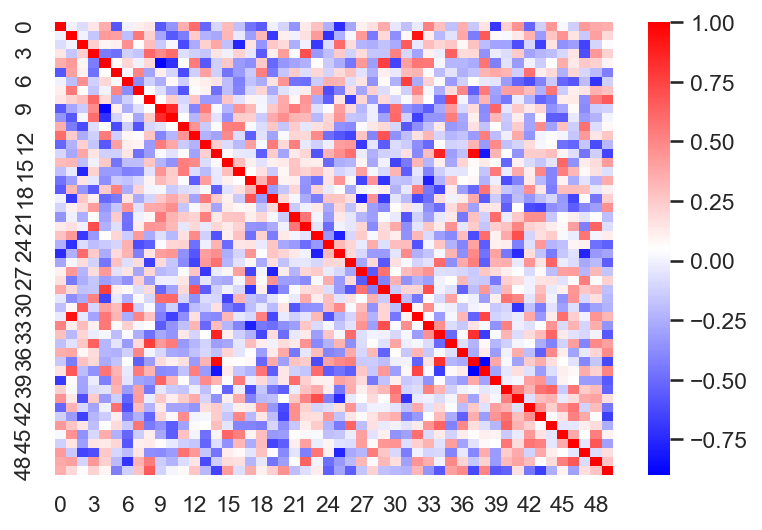

"One way to do this is to assign a lower coef for highly correlated features, if you belive that there shouldn't be any highly\n   correlated features. That assumption is important, because otherwise you're discarding important performance."

In [52]:
'''Some fake correlations (fake news) by making random and uncorrelated data and looking for correlations.
   This is called a false discovery (false discorvery rate = FDR) and this needs to be strongly penalized!'''
X = np.random.uniform(-4,4,size=(10,50))
cors = np.corrcoef(np.transpose(X))
sns.heatmap(cors,cmap='bwr')
plt.show()
'''One way to do this is to assign a lower coef for highly correlated features, if you belive that there shouldn't be any highly
   correlated features. That assumption is important, because otherwise you're discarding important performance.'''

## <font color='navy'> The difference between L1 and L2 norms </font>

In the following example the L2 norm of the vector $\vec{AB}$ is 5 and the L1 norm is $4+3=7$.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1IIy5df8JcgHcI8oWxJbze9PiW_cUaIZD' 
width='550px' />
<figcaption>The difference between the L1 and L2 norms</figcaption></center>
</figure>


## <font color= 'navy'> L2 Regularization - Tikhonov 1940's </font>

The L2 norm is 

$$
\|\beta\|_2:=\sqrt{\sum_{j=1}^{p}\beta_j^2}
$$

The Ridge model (also known as the *Tikhonov regularization*) consists of *learning* the weights by the following optimization:

$$\text{minimize} \frac{1}{n}\sum_{i=1}^{n}\left(\text{Residual}_i\right)^2 + \alpha \sum\limits_{j=1}^{p}\beta_j^2$$

where $alpha$ is a constant that can be adjusted based on a feedback loop so it is a hyperparameter.

The hyperparameter $\alpha$ is becoming a "tuning" parameter.

This optimization is equivalent to minimizing the sum of the square residuals with a constraint on the sum of the squared weights

$$\text{minimize} \frac{1}{n}\sum_{i=1}^{n}\left(\text{Residual}_i\right)^2$$

subject to 

$$
 \sum\limits_{j=1}^{p}\beta_j^2 < M
$$

## <font color= 'navy'> L1 Regularization as known as Lasso (Tibshirani, 1993) </font>

The L1 norm is 

$$
\|\beta\|_1:=\sum_{j=1}^{p}|\beta_j|
$$

The Lasso model  consists of *learning* the weights by the following optimization:

$$\text{minimize} \frac{1}{n}\sum_{i=1}^{n}\left(\text{Residual}_i\right)^2 + \alpha \|\beta\|_1$$

where $alpha$ is a constant that can be adjusted based on a feedback loop so it is a hyperparameter.

This optimization is equivalent to minimizing the sum of the square residuals with a constraint on the sum of the squared weights

$$\text{minimize} \frac{1}{n}\sum_{i=1}^{n}\left(\text{Residual}_i\right)^2$$

subject to 

$$
 \sum\limits_{j=1}^{p}|\beta_j| < M
$$

##<font color='navy'> Geometric comparison in 2D between L1 and L2 norms

<figure>
<center>
<img src='https://drive.google.com/uc?id=13uBQRlI_-LNfA8yLphY3fHChoEbjqOEW' 
width='500px' />
<figcaption>Difference between L1 and L2</figcaption></center>
</figure>


##<font color= 'navy'> Elastic Net Regularization (2005) </font>

Tha main idea is to combine the L2 and L1 regularizations in a *convex* way, such as:

$$
\lambda\cdot \sum\limits_{j=1}^{p}|\beta_j| + (1-\lambda)\cdot\sum\limits_{j=1}^{p}\beta_j^2
$$

Here $0\leq\lambda\leq1$, $\alpha$ is formulated via the ratio between the two penalties such as $\text{L1}_{ratio}=\frac{\lambda}{1 - \lambda}$

The Elstic Net regularization consists of *learning* the weights by solving the following optimization problem:

$$\text{minimize} \frac{1}{n}\sum_{i=1}^{n}\left(\text{Residual}_i\right)^2 + \alpha\left( \lambda\cdot \sum\limits_{j=1}^{p}|\beta_j| + (1-\lambda)\cdot\sum\limits_{j=1}^{p}\beta_j^2\right)$$

So with this rgularization approach we have two hyperparameters that we need to decide on.

In [37]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [38]:
df = pd.read_csv('Data/Boston_Housing_Prices.csv')
df

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Winthrop,1801,-70.986000,42.231201,0.06263,0.0,11.93,no,0.573,6.593,69.099998,2.4786,1,273,21.000000,9.67,22.400000
502,Winthrop,1802,-70.990997,42.227501,0.04527,0.0,11.93,no,0.573,6.120,76.699997,2.2875,1,273,21.000000,9.08,20.600000
503,Winthrop,1803,-70.994797,42.226002,0.06076,0.0,11.93,no,0.573,6.976,91.000000,2.1675,1,273,21.000000,5.64,23.900000
504,Winthrop,1804,-70.987503,42.223999,0.10959,0.0,11.93,no,0.573,6.794,89.300003,2.3889,1,273,21.000000,6.48,22.000000


In [5]:
features = ['crime','rooms','residential','industrial','nox','older','distance','highway','tax','ptratio','lstat']
X = np.array(df[features])
y = np.array(df['cmedv']).reshape(-1,1)
dat = np.concatenate([X,y], axis=1)

## How do we know we have strong correlations in the data?

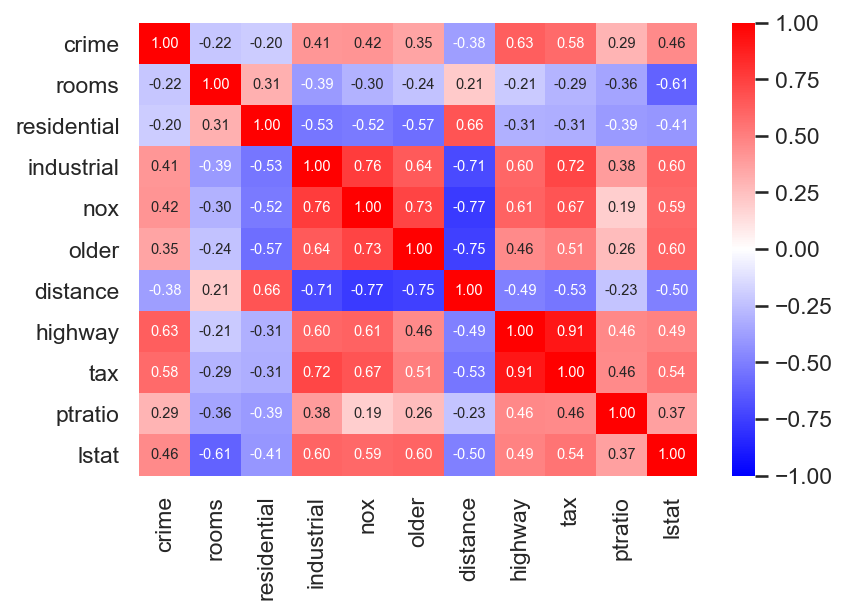

In [6]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
sns.set(color_codes=True)
cols = features
sns.heatmap(np.corrcoef(np.transpose(X)),cmap='bwr',vmin=-1,vmax=1,annot=True,fmt='.2f',annot_kws={"size": 7},xticklabels=cols,yticklabels=cols)
plt.show()

## We need to determine the significance of the correlation coeffcients:

### Test statistic for the corelation coefficient:

$$\large t=\frac{r\sqrt{n-2}}{\sqrt{1-r^2}}$$

where $n$ is the number of observations and $r$ represents the correlation coefficient computed from the data.

In [7]:
n = len(X)
n

506

In [8]:
def tstat_corr(r,n):
  from scipy import stats
  t = r*np.sqrt(n-2)/np.sqrt(1-r**2)
  pval = stats.t.sf(np.abs(t), n-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
  print('t-statistic = %6.3f pvalue = %6.4f' % (t, pval))

In [9]:
tstat_corr(0.16,len(X))

t-statistic =  3.639 pvalue = 0.0003


## This means we have strong correlations and we need to apply a form of regularization when train our models.

In [10]:
from sklearn.model_selection import train_test_split as tts
dat_train, dat_test = tts(dat, test_size=0.3, random_state=1234)

In [11]:
model = LinearRegression()
model.fit(dat_train[:,:-1],dat_train[:,-1])
yhat_lm = model.predict(dat_test[:,:-1])
mae_lm = mean_absolute_error(dat_test[:,-1], yhat_lm)
print("MAE Linear Model (no regularization) = ${:,.2f}".format(1000*mae_lm))

MAE Linear Model (no regularization) = $3,640.02


In [12]:
model = ElasticNet(alpha=0.01,l1_ratio=0.01)
model.fit(dat_train[:,:-1],dat_train[:,-1])
yhat_en = model.predict(dat_test[:,:-1])
mae_en = mean_absolute_error(dat_test[:,-1], yhat_en)
print("MAE Linear Model (no regularization) = ${:,.2f}".format(1000*mae_en))

MAE Linear Model (no regularization) = $3,610.42


## There are more techniques for regularization (including Smoothly Clipped Absolute Deviations - SCAD and the Square Root Lasso)

https://andrewcharlesjones.github.io/posts/2020/03/scad/

In [13]:
def scad_penalty(beta_hat, lambda_val, a_val):
    is_linear = (np.abs(beta_hat) <= lambda_val)
    is_quadratic = np.logical_and(lambda_val < np.abs(beta_hat), np.abs(beta_hat) <= a_val * lambda_val)
    is_constant = (a_val * lambda_val) < np.abs(beta_hat)
    
    linear_part = lambda_val * np.abs(beta_hat) * is_linear
    quadratic_part = (2 * a_val * lambda_val * np.abs(beta_hat) - beta_hat**2 - lambda_val**2) / (2 * (a_val - 1)) * is_quadratic
    constant_part = (lambda_val**2 * (a_val + 1)) / 2 * is_constant
    return linear_part + quadratic_part + constant_part
    
def scad_derivative(beta_hat, lambda_val, a_val):
    return lambda_val * ((beta_hat <= lambda_val) + (a_val * lambda_val - beta_hat)*((a_val * lambda_val - beta_hat) > 0) / ((a_val - 1) * lambda_val) * (beta_hat > lambda_val))

In [14]:
lam = 0.1
a = 80

In [15]:
beta = np.arange(-10,10,.01)
y = scad_penalty(beta,lam,a)

In [16]:
y

array([0.405, 0.405, 0.405, ..., 0.405, 0.405, 0.405])

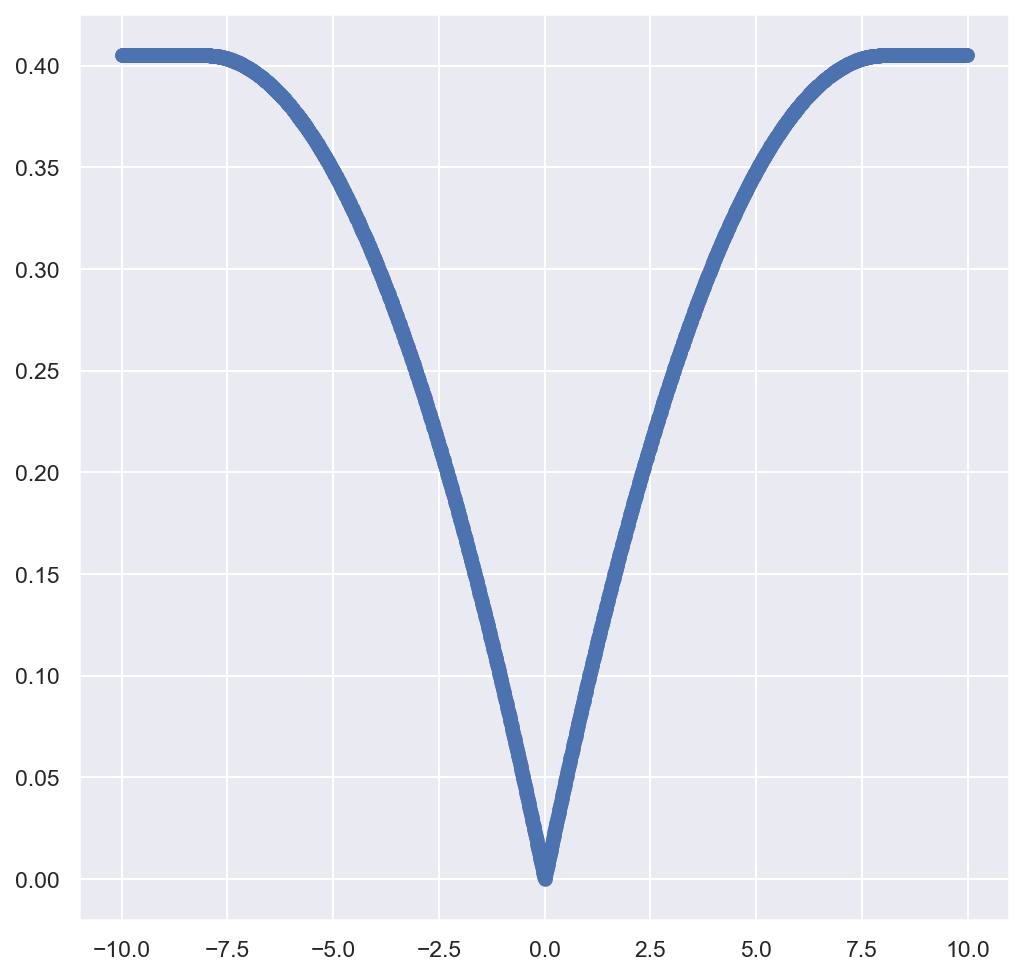

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(beta,y)

In [20]:
beta_ridge= np.matmul(np.linalg.inv(np.matmul(np.transpose(X),X)+lam*np.identity(11)),np.matmul(np.transpose(X),y))
beta_ridge


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2000 is different from 506)

## Polynomial Features

IMPORTANT: polynomials are linear combinations of powers of x or of the input features (we can also have interactions between features)

In [29]:
import operator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 150

16.109919111586507
0.6328945168369458


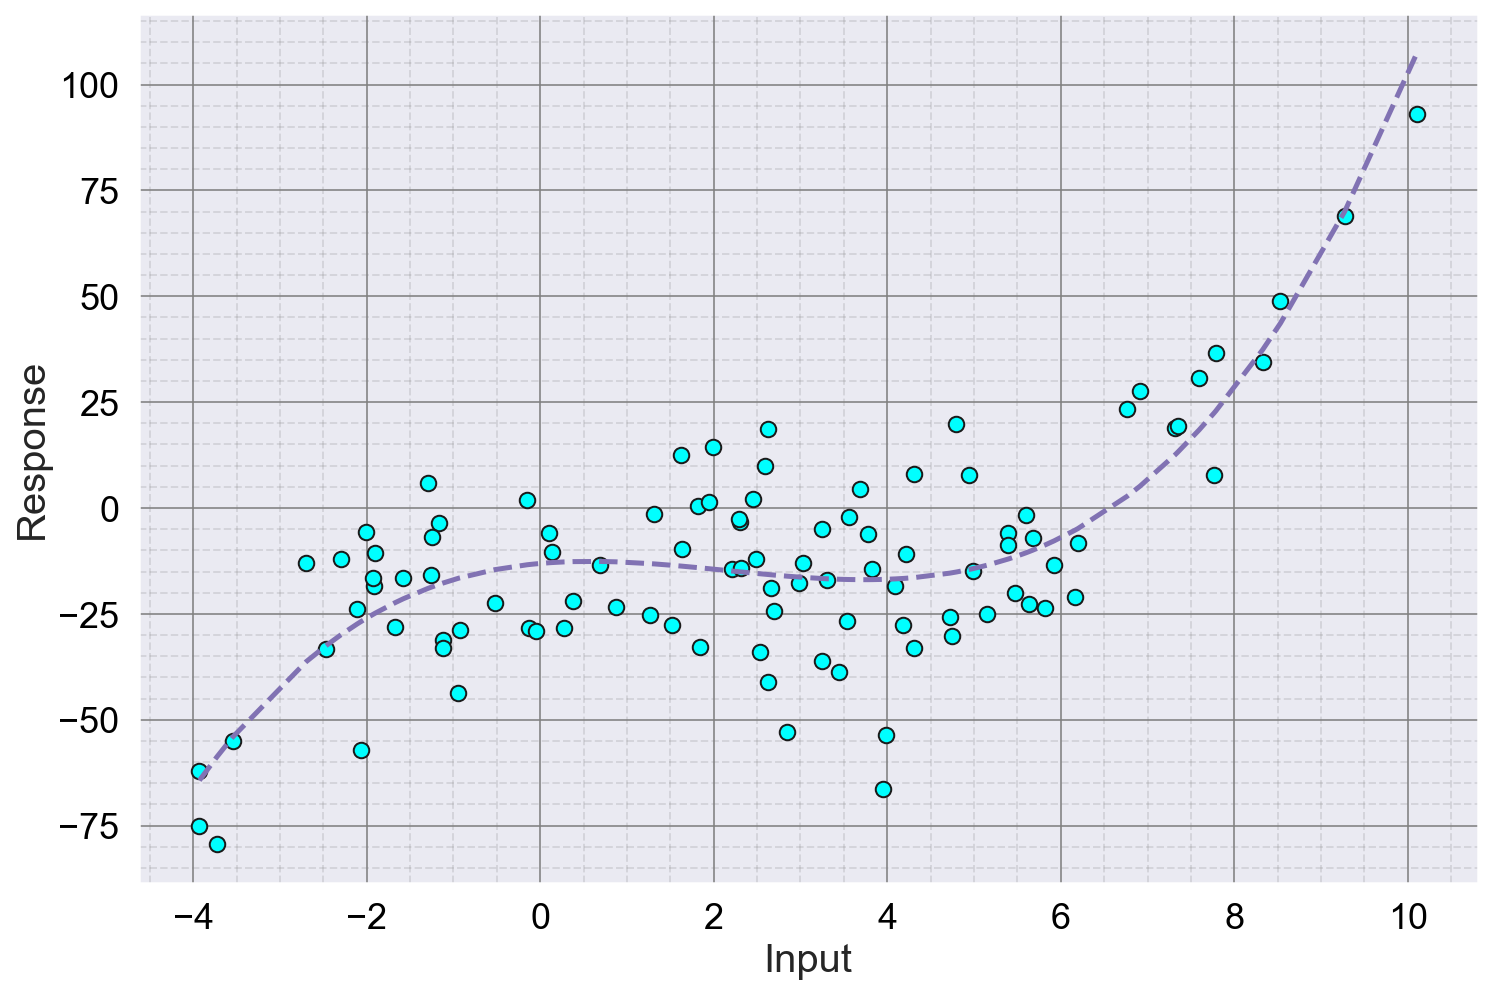

In [31]:
np.random.seed(1693)
x = 2 - 3 * np.random.normal(0, 1, 100)

def f(x):
    sz = len(x)
    return x - 1.5 * (x ** 2) + 0.25 * (x ** 3) + 5 * np.random.normal(-3, 3, sz)

y = f(x)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x.reshape((-1,1)))

# the model created is linear in weights 
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x, y, color='cyan',edgecolors='k',s=60)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
ax.plot(x, y_poly_pred, color='m',linestyle='--',lw=2.5)
ax.set_xlabel('Input',fontsize=20)
ax.set_ylabel('Response',fontsize=20)
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
plt.tick_params(axis='x', colors='black',labelsize=18)
plt.tick_params(axis='y', colors='black',labelsize=18)
ax.minorticks_on()
plt.show()

### Now we want to create polynomial features for our real data and try regularized regression

In [32]:
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X)

In [33]:
model = Ridge(alpha=1)

In [34]:
model.fit(polynomial_features.fit_transform(dat_train[:,:-1]),dat_train[:,-1])
yhat_lp = model.predict(polynomial_features.fit_transform(dat_test[:,:-1]))
mae_lp = mean_absolute_error(dat_test[:,-1], yhat_lp)
print("MAE Polynomial Model = ${:,.2f}".format(1000*mae_lp))

MAE Polynomial Model = $2,392.79


## Neural Network Approach

In [36]:
# imports for creating a Neural Networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [37]:
dat_train[:,:-1].shape

(354, 11)

In [38]:
# Create a Neural Network model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=11))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=800)

# Fit the model
history = model.fit(dat_train[:,:-1], dat_train[:,11], validation_split=0.3, epochs=1000, batch_size=100, verbose=0, callbacks=[es])

# Calculate predictions
#yhat_nn = model.predict(X_test)

C:\Users\mnelk\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Here are the predictions we made for the test data:

In [39]:
yhat_nn = model.predict(dat_test[:,:-1])
mae_nn = mean_absolute_error(dat_test[:,-1], yhat_nn)
print("MAE Neural Network = ${:,.2f}".format(1000*mae_nn))

MAE Neural Network = $2,542.58


In [40]:
from sklearn.model_selection import KFold

In [41]:
kf = KFold(n_splits=10, shuffle=True, random_state=1693)

In [42]:
#%%timeit -n 1

mae_nn = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0:-1]
  y_train = dat[idxtrain,-1]
  X_test  = dat[idxtest,0:-1]
  y_test = dat[idxtest,-1]
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=800)
  model.fit(X_train,y_train,validation_split=0.3, epochs=1000, batch_size=100, verbose=0, callbacks=[es])
  yhat_nn = model.predict(X_test)
  mae_nn.append(mean_absolute_error(y_test, yhat_nn))
print("Validated MAE Neural Network Regression = ${:,.2f}".format(1000*np.mean(mae_nn)))

KeyboardInterrupt: 

## XGBoost

The method is related to Random Forest

https://towardsdatascience.com/xgboost-python-example-42777d01001e

In [ ]:
import xgboost as xgb

In [ ]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=1,alpha=1,gamma=1,max_depth=10)

In [ ]:
model_xgb.fit(dat_train[:,:-1],dat_train[:,-1])
yhat_xgb = model_xgb.predict(dat_test[:,:-1])
mae_xgb = mean_absolute_error(dat_test[:,-1], yhat_xgb)
print("MAE Polynomial Model = ${:,.2f}".format(1000*mae_xgb))

MAE Polynomial Model = $2,020.19


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


In [ ]:
%%timeit -n 1

mae_xgb = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0:-1]
  y_train = dat[idxtrain,-1]
  X_test  = dat[idxtest,0:-1]
  y_test = dat[idxtest,-1]
  model_xgb.fit(X_train,y_train)
  yhat_xgb = model_xgb.predict(X_test)
  mae_xgb.append(mean_absolute_error(y_test, yhat_xgb))
print("Validated MAE XGBoost Regression = ${:,.2f}".format(1000*np.mean(mae_xgb)))

## Using Kernel Regression from StatsModels

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
model_KernReg = KernelReg(endog=dat_train[:,-1],exog=dat_train[:,:-1],var_type='ccccccccccc',ckertype='gaussian')

In [ ]:
yhat_sm_test, y_std = model_KernReg.fit(dat_test[:,:-1])

In [ ]:
mae_sm = mean_absolute_error(dat_test[:,-1], yhat_sm_test)
print("MAE StatsModels Kernel Regression = ${:,.2f}".format(1000*mae_sm))

MAE StatsModels Kernel Regression = $2,846.43
